In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
!mkdir data

In [7]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [8]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [9]:
df = pd.io.sql.read_sql(
    """
    select uid, labname, numTrials, timestamp
    from checker
    where uid like 'user_%' and status = 'ready'
    """,
    conn, parse_dates=['timestamp']
    )

In [10]:
df.head()

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104


In [11]:
conn.close()

In [12]:
df['hour'] = df['timestamp'].dt.hour
dayofweek = df['timestamp'].dt.dayofweek
df = df.drop('timestamp', axis=1)

In [13]:
df.head()

,uid,labname,numTrials,hour
0,user_4,project1,1,5
1,user_4,project1,2,5
2,user_4,project1,3,5
3,user_4,project1,4,5
4,user_4,project1,5,5


In [14]:
df = pd.get_dummies(df, prefix=['uid', 'labname'], columns=['uid', 'labname'])

In [15]:
scaler = StandardScaler()

In [16]:
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])

In [17]:
df['dayofweek'] = dayofweek

In [18]:
df.head()

,numTrials,hour,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,dayofweek
0,-0.788667,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
1,-0.756764,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
2,-0.724861,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
3,-0.692958,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,-0.661055,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4


In [19]:
df.shape

(1686, 44)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numTrials         1686 non-null   float64
 1   hour              1686 non-null   float64
 2   uid_user_0        1686 non-null   uint8  
 3   uid_user_1        1686 non-null   uint8  
 4   uid_user_10       1686 non-null   uint8  
 5   uid_user_11       1686 non-null   uint8  
 6   uid_user_12       1686 non-null   uint8  
 7   uid_user_13       1686 non-null   uint8  
 8   uid_user_14       1686 non-null   uint8  
 9   uid_user_15       1686 non-null   uint8  
 10  uid_user_16       1686 non-null   uint8  
 11  uid_user_17       1686 non-null   uint8  
 12  uid_user_18       1686 non-null   uint8  
 13  uid_user_19       1686 non-null   uint8  
 14  uid_user_2        1686 non-null   uint8  
 15  uid_user_20       1686 non-null   uint8  
 16  uid_user_21       1686 non-null   uint8  


In [21]:
df.to_csv('data/dayofweek.csv', index=False)

In [23]:
uploaded = drive.CreateFile({'title': 'dayofweek.csv'})
uploaded.SetContentFile('data/dayofweek.csv')
uploaded.Upload()

In [24]:
X = df.drop('dayofweek', axis=1)
y = dayofweek

In [25]:
y_pred_naive = np.array([np.argmax(np.bincount(y))] * len(y))

In [26]:
accuracy_score(y, y_pred_naive)

0.23487544483985764

In [28]:
def plot_feature_importances(coefs, features, n=10):
    fig, ax = plt.subplots(figsize=(15, 8))
    coefs /= coefs.sum()
    indices = coefs.argsort()[::-1][:n]
    ax.barh(np.arange(n), coefs[indices], color='mediumslateblue')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(features[indices])
    ax.invert_yaxis()
    plt.show()

In [31]:
clf = LogisticRegression(random_state=21, fit_intercept=False)

In [32]:
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred = clf.predict(X)

In [34]:
accuracy_score(y, y_pred)

0.6405693950177936

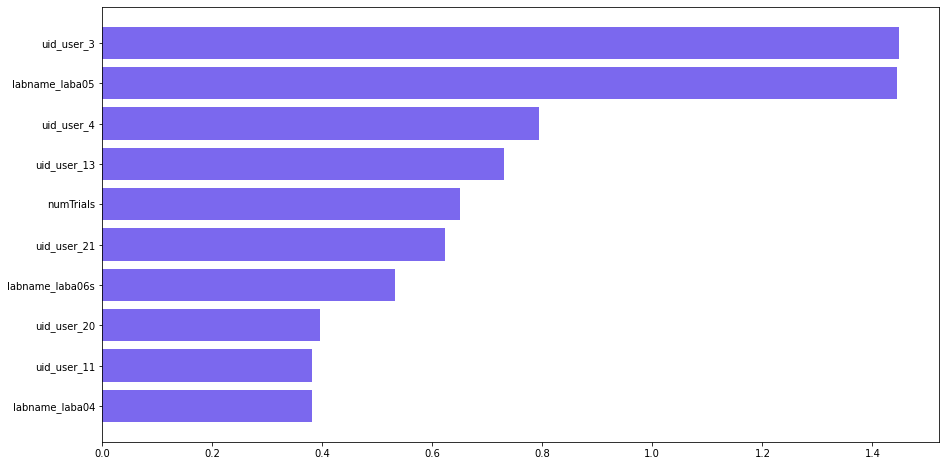

In [35]:
plot_feature_importances(clf.coef_.mean(axis=0), X.columns)

In [37]:
clf = SVC(probability=True, random_state=21)

In [38]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

cv = GridSearchCV(clf, param_grid, scoring='accuracy')

In [39]:
cv.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=21, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [40]:
cv.best_params_

{'kernel': 'poly'}

In [41]:
y_pred = cv.predict(X)

In [42]:
accuracy_score(y, y_pred)

0.8594306049822064

In [43]:
clf = SVC(kernel='linear', probability=True, random_state=21)

In [44]:
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=21, shrinking=True, tol=0.001,
    verbose=False)

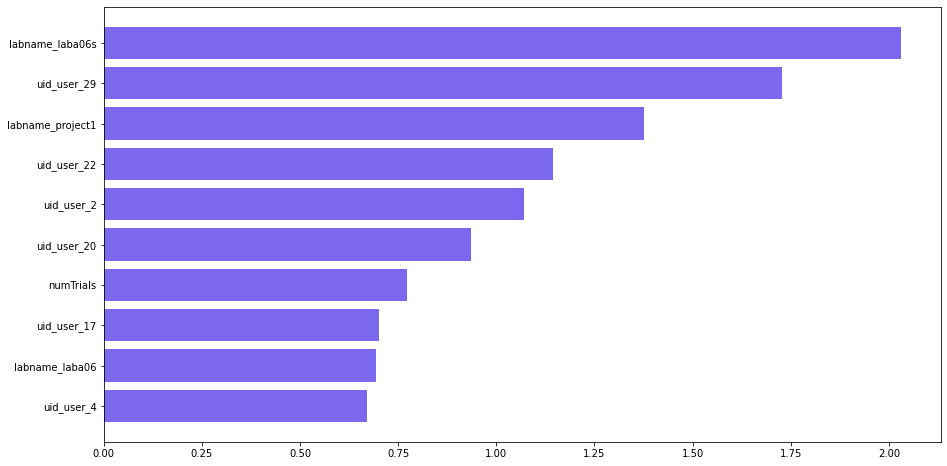

In [45]:
plot_feature_importances(clf.coef_.mean(axis=0), X.columns)

In [60]:
clf = DecisionTreeClassifier(random_state=21)

In [61]:
param_grid = {'max_depth': np.arange(3, 21)}

cv = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1)

In [62]:
cv.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=21,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11

In [63]:
cv.best_params_

{'max_depth': 16}

In [64]:
y_pred = cv.predict(X)

In [65]:
accuracy_score(y, y_pred)

0.9608540925266904

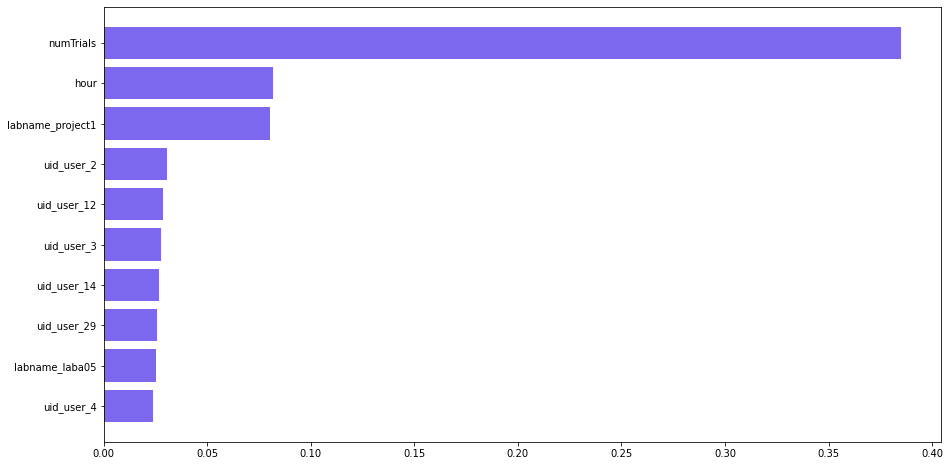

In [66]:
plot_feature_importances(cv.best_estimator_.feature_importances_, X.columns)

In [67]:
clf = RandomForestClassifier(random_state=21)

In [69]:
param_grid = {'n_estimators': np.arange(10, 200, 10),
              'max_depth': np.arange(3, 21)}

cv = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1)

In [70]:
cv.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=21,
                               

In [71]:
cv.best_params_

{'max_depth': 13, 'n_estimators': 30}

In [72]:
y_pred = cv.predict(X)

In [73]:
accuracy_score(y, y_pred)

0.9483985765124555

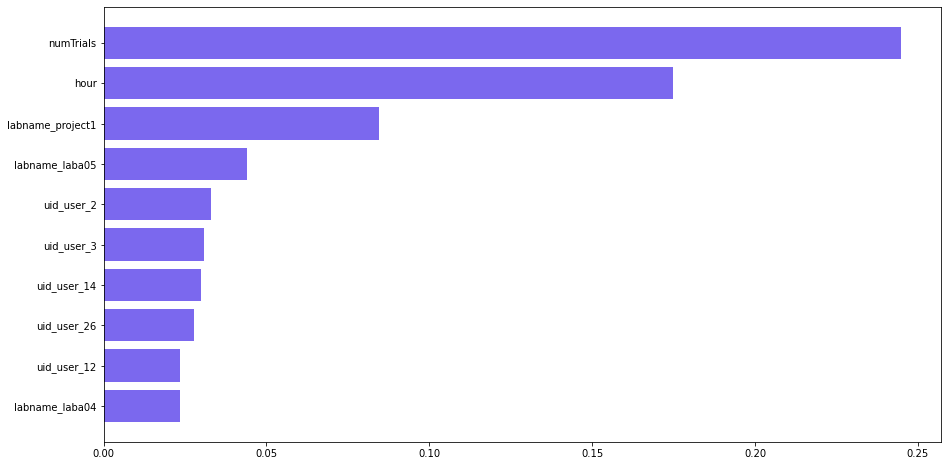

In [74]:
plot_feature_importances(cv.best_estimator_.feature_importances_, X.columns)